In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np


import os
os.chdir("../")
from Sources.tools import *

# Load data

In [2]:
df_technical = get_technical_df()
df_fundamental = get_fundamental_df()

# Pre process data

## Technical data

In [3]:
windows_df = create_windows_dataframe(df_technical)
filtered_windows_df = filter_actions_complete_years(windows_df)

len_tot = len(filtered_windows_df)
actions_nb = len(np.unique(filtered_windows_df["Name"]))
print(f"Total : {len_tot} données\nActions : {actions_nb}")

Total : 465 données
Actions : 93


In [4]:
filtered_windows_df

,Name,year,tech_window,target_window
0,AAPL,2017,"[27.487499237060547, 27.51499938964844, 27.932...","[29.037500381469727, 29.0049991607666, 29.1525..."
1,AAPL,2018,"[42.775001525878906, 42.53749847412109, 42.494...","[43.06499862670898, 43.057498931884766, 43.257..."
2,AAPL,2019,"[47.852500915527344, 48.38249969482422, 46.465...","[39.47999954223633, 35.54750061035156, 37.0649..."
3,AAPL,2020,"[66.7750015258789, 66.57250213623047, 65.79750...","[75.0875015258789, 74.35749816894531, 74.94999..."
4,AAPL,2021,"[118.02999877929688, 118.63999938964844, 117.3...","[129.41000366210938, 131.00999450683594, 126.5..."
...,...,...,...,...
460,XLNX,2017,"[53.2400016784668, 52.97999954223633, 53.13000...","[59.06999969482422, 58.63999938964844, 57.9300..."
461,XLNX,2018,"[72.66999816894531, 71.80999755859375, 72.6399...","[67.87999725341797, 69.23999786376953, 70.4899..."
462,XLNX,2019,"[88.51000213623047, 90.54000091552734, 87.9199...","[86.8499984741211, 83.58000183105469, 87.44999..."
463,XLNX,2020,"[92.37999725341795, 92.8000030517578, 91.01000...","[101.6500015258789, 99.30999755859376, 97.2399..."


## Fundamental data

In [5]:
df_transformed = transform_fundamentals(df_fundamental)
df_cleaned = fill_missing_values(df_transformed)
df_filled = fill_nan_with_yearly_mean(df_cleaned)

df_filled.rename(columns={'symbol': 'Name'}, inplace=True)
fund_features = df_filled.columns.tolist()[2:]

d:\Developpement\Deep_Learning_3A_CS\technical_and_fundamental_analysis_in_stock_market\Sources\tools.py:221: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_filled = df_filled.groupby("symbol").apply(lambda group: group.interpolate(method='linear').ffill().bfill())
d:\Developpement\Deep_Learning_3A_CS\technical_and_fundamental_analysis_in_stock_market\Sources\tools.py:221: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_filled = df_filled.groupby("symbol").apply(lambda group: group.interpolate(method='linear').ffill().bfill())
d:\Developpement\Deep_Learning_3A_CS\technical_and_fundamental_analysis_in_stock_market\Sources\tools.py:221: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future versio

In [6]:
df_filled

indicator,Name,year,asset_turnover,buyback_yield,capex_to_revenue,cash_ratio,cash_to_debt,cogs_to_revenue,current_ratio,days_inventory,...,price_to_earnings_ratio,price_to_earnings_ratio_nri,price_to_free_cashflow,price_to_operating_cashflow,rate_of_return,scaled_net_operating_assets,yoy_ebitda_growth,yoy_eps_growth,yoy_revenue_growth,zscore
0,AAPL,2017,0.66,4.09,0.05,0.74,0.64,0.62,1.28,9.040000,...,16.730000,16.730000,15.63,12.60,19.240000,0.55,9.36,10.83,11.34,3.62
1,AAPL,2018,0.72,6.71,0.05,0.57,0.58,0.62,1.13,9.820000,...,18.940000,18.940000,17.60,14.58,17.240000,0.41,19.40,29.40,21.69,4.22
2,AAPL,2019,0.74,6.64,0.04,0.95,0.93,0.62,1.54,9.090000,...,18.850000,18.850000,17.68,15.00,13.600000,0.27,1.15,-0.34,5.36,4.24
3,AAPL,2020,0.83,3.64,0.03,0.86,0.81,0.62,1.36,8.790000,...,35.310000,35.310000,27.67,25.16,9.700000,0.26,5.00,10.44,11.94,6.33
4,AAPL,2021,1.08,3.65,0.03,0.50,0.50,0.58,1.07,9.120000,...,25.220000,25.220000,25.67,22.94,16.130000,0.39,57.96,71.04,38.50,6.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,ZS,2018,0.60,-4.77,0.08,1.63,1.51,0.20,2.12,85.381014,...,51.892944,52.045722,372.88,130.30,16.343171,-0.32,-40.07,-44.83,145.42,12.35
503,ZS,2019,0.58,-4.77,0.10,1.39,1.51,0.20,1.89,90.975286,...,59.780333,59.985333,372.88,179.30,15.361098,-0.13,64.83,63.49,-17.67,22.06
504,ZS,2020,0.35,-4.77,0.12,3.23,1.51,0.22,3.73,87.325286,...,79.772111,79.487667,609.62,211.83,13.297317,0.03,-400.75,-286.96,36.07,8.21
505,ZS,2021,0.33,-4.77,0.09,2.09,1.56,0.22,2.57,81.379571,...,59.726889,61.688111,222.56,158.44,12.161585,-0.01,-86.74,-116.85,48.79,11.58


## Merge

In [7]:
df_all = pd.merge(filtered_windows_df, df_filled, how="inner", on=["Name", "year"])

In [8]:
df_all

,Name,year,tech_window,target_window,asset_turnover,buyback_yield,capex_to_revenue,cash_ratio,cash_to_debt,cogs_to_revenue,...,price_to_earnings_ratio,price_to_earnings_ratio_nri,price_to_free_cashflow,price_to_operating_cashflow,rate_of_return,scaled_net_operating_assets,yoy_ebitda_growth,yoy_eps_growth,yoy_revenue_growth,zscore
0,AAPL,2017,"[27.487499237060547, 27.51499938964844, 27.932...","[29.037500381469727, 29.0049991607666, 29.1525...",0.66,4.09,0.05,0.74,0.64,0.62,...,16.73,16.73,15.630000,12.60,19.24,0.55,9.36,10.83,11.34,3.62
1,AAPL,2018,"[42.775001525878906, 42.53749847412109, 42.494...","[43.06499862670898, 43.057498931884766, 43.257...",0.72,6.71,0.05,0.57,0.58,0.62,...,18.94,18.94,17.600000,14.58,17.24,0.41,19.40,29.40,21.69,4.22
2,AAPL,2019,"[47.852500915527344, 48.38249969482422, 46.465...","[39.47999954223633, 35.54750061035156, 37.0649...",0.74,6.64,0.04,0.95,0.93,0.62,...,18.85,18.85,17.680000,15.00,13.60,0.27,1.15,-0.34,5.36,4.24
3,AAPL,2020,"[66.7750015258789, 66.57250213623047, 65.79750...","[75.0875015258789, 74.35749816894531, 74.94999...",0.83,3.64,0.03,0.86,0.81,0.62,...,35.31,35.31,27.670000,25.16,9.70,0.26,5.00,10.44,11.94,6.33
4,AAPL,2021,"[118.02999877929688, 118.63999938964844, 117.3...","[129.41000366210938, 131.00999450683594, 126.5...",1.08,3.65,0.03,0.50,0.50,0.58,...,25.22,25.22,25.670000,22.94,16.13,0.39,57.96,71.04,38.50,6.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,XEL,2017,"[39.0, 38.869998931884766, 39.34000015258789, ...","[40.619998931884766, 40.79999923706055, 40.799...",0.27,0.01,0.28,0.02,0.01,0.60,...,21.38,21.38,42.157887,7.83,3.26,0.66,4.50,1.81,2.68,1.02
406,XEL,2018,"[51.18000030517578, 50.88999938964844, 50.5900...","[47.810001373291016, 47.4900016784668, 47.1199...",0.26,-0.90,0.34,0.03,0.01,0.61,...,19.95,19.95,55.808763,8.06,3.89,0.68,-1.11,9.78,0.77,0.96
407,XEL,2019,"[51.369998931884766, 51.060001373291016, 51.61...","[48.220001220703125, 48.02999877929688, 48.5]",0.24,-1.38,0.37,0.05,0.01,0.59,...,24.05,24.05,59.876186,10.12,3.35,0.73,4.34,6.88,-1.80,1.02
408,XEL,2020,"[60.880001068115234, 61.31999969482422, 61.689...","[62.380001068115234, 62.68000030517578, 62.590...",0.22,-2.03,0.47,0.03,0.01,0.57,...,23.90,23.90,81.350704,12.36,0.09,0.73,3.39,5.68,-1.54,1.03


# Split data

In [9]:
tech_features = 1  # Si `tech_window` ne contient que le prix de clôture

train_years = [2017, 2018, 2019]
val_years = [2020]
test_years = [2021]

df_train, df_val, df_test = split_data_by_year(df_all, train_years, val_years, test_years)

# Préparer les entrées/sorties
X_train_tech, X_train_fund, y_train = prepare_model_inputs(df_train, tech_features, fund_features)
X_val_tech, X_val_fund, y_val = prepare_model_inputs(df_val, tech_features, fund_features)
X_test_tech, X_test_fund, y_test = prepare_model_inputs(df_test, tech_features, fund_features)

# Model

In [69]:
# Paramètres d'exemple
timesteps = 30           # par exemple, 30 jours de données techniques
n_tech_features = 1     # nombre de caractéristiques techniques (prix, indicateurs, etc.)
n_fund_features = len(fund_features)     # nombre de ratios fondamentaux

# --- Branche technique ---
tech_input = Input(shape=(timesteps, n_tech_features), name='tech_input')
tech_lstm = LSTM(64, return_sequences=True)(tech_input)  # retourne une séquence

# --- Branche fondamentale ---
fund_input = Input(shape=(n_fund_features,), name='fund_input')
fund_dense = Dense(32, activation='relu')(fund_input)
fund_dense = Dense(16, activation='relu')(fund_dense)
# Répéter les caractéristiques fondamentales pour chaque jour de la séquence
fund_repeated = RepeatVector(timesteps)(fund_dense)

# --- Fusion des branches ---
combined = Concatenate(axis=-1)([tech_lstm, fund_repeated])

# # --- Prédiction finale ---
# # On peut passer le résultat fusionné dans une nouvelle LSTM pour capturer des dynamiques sur la séquence enrichie
# final_lstm = LSTM(32, return_sequences=True)(combined)
# output = TimeDistributed(Dense(1, activation='linear'))(final_lstm)

# --- Prédiction finale ---
final_lstm = LSTM(32, return_sequences=False)(combined)  # Pas de séquence, juste un vecteur
output = Dense(3, activation='linear')(final_lstm)  # Prédire 3 valeurs directement

# Définition et compilation du modèle
model = Model(inputs=[tech_input, fund_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=["mse"])

# Affichage de la structure du modèle
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ fund_input          │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │      1,280 │ fund_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tech_input          │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 16)        │        528 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 30, 64)    │     16,896 │ tech_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 30, 16)    │          0 │ dense_19[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 30, 80)    │          0 │ lstm_12[0][0],    │
│ (Concatenate)       │                   │            │ repeat_vector_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 32)        │     14,464 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 3)         │         99 │ lstm_13[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,267 (129.95 KB)

 Trainable params: 33,267 (129.95 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
early_stopping = EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)

history = model.fit([X_train_tech, X_train_fund], y_train, 
          validation_data=([X_val_tech, X_val_fund], y_val),
          epochs=10000, batch_size=32)

Epoch 1/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 93786.6016 - mse: 93786.6016 - val_loss: 172940.3125 - val_mse: 172940.3125
Epoch 2/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 100139.4219 - mse: 100139.4219 - val_loss: 172778.4375 - val_mse: 172778.4375
Epoch 3/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 102618.8359 - mse: 102618.8359 - val_loss: 172627.4375 - val_mse: 172627.4375
Epoch 4/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 72648.2656 - mse: 72648.2656 - val_loss: 172495.3438 - val_mse: 172495.3438
Epoch 5/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 124124.3750 - mse: 124124.3750 - val_loss: 172335.9375 - val_mse: 172335.9375
Epoch 6/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 76801.7969 - mse: 76801.7969 - val_loss: 172145.7969 - val_mse: 172145.7969
Epoch 7/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 107116.5547 - mse: 107116.5547 - val_loss: 171975.0625 - val_mse: 171975.0625
Epoch 8/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0

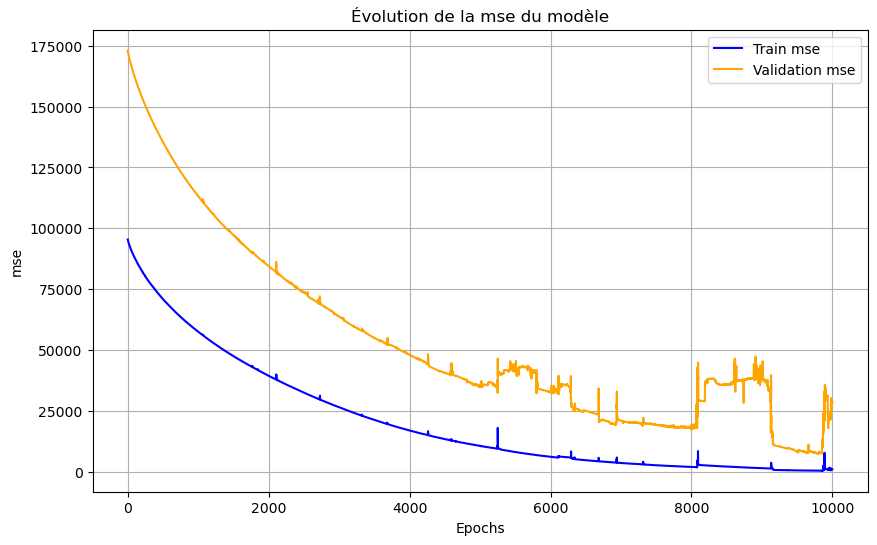

In [71]:
plot_training_curves(history, "mse")

## Train

In [72]:
y_pred_train = model.predict([X_train_tech, X_train_fund])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [73]:
get_performance_metrics_multiple_days(y_train, y_pred_train)

{'Day 1': {'RMSE': np.float64(31.750726280504537),
  'MAE': 6.725742011511025,
  'R²': 0.9854503520741904,
  'NMAE': np.float64(0.04211821484148892),
  'Accuracy': np.float64(5.46218487394958),
  'MAPE': 1.9739355822769238,
  'SMAPE': np.float64(1.964524114312477)},
 'Day 2': {'RMSE': np.float64(32.254928429237005),
  'MAE': 7.657863893428771,
  'R²': 0.9848793673427699,
  'NMAE': np.float64(0.04811957593812557),
  'Accuracy': np.float64(2.100840336134454),
  'MAPE': 2.769067155691334,
  'SMAPE': np.float64(2.753840207392731)},
 'Day 3': {'RMSE': np.float64(31.480544515057492),
  'MAE': 7.1003022514471485,
  'R²': 0.9861363656299907,
  'NMAE': np.float64(0.043809310429811954),
  'Accuracy': np.float64(3.361344537815126),
  'MAPE': 2.4348269747015334,
  'SMAPE': np.float64(2.4334654771469397)}}

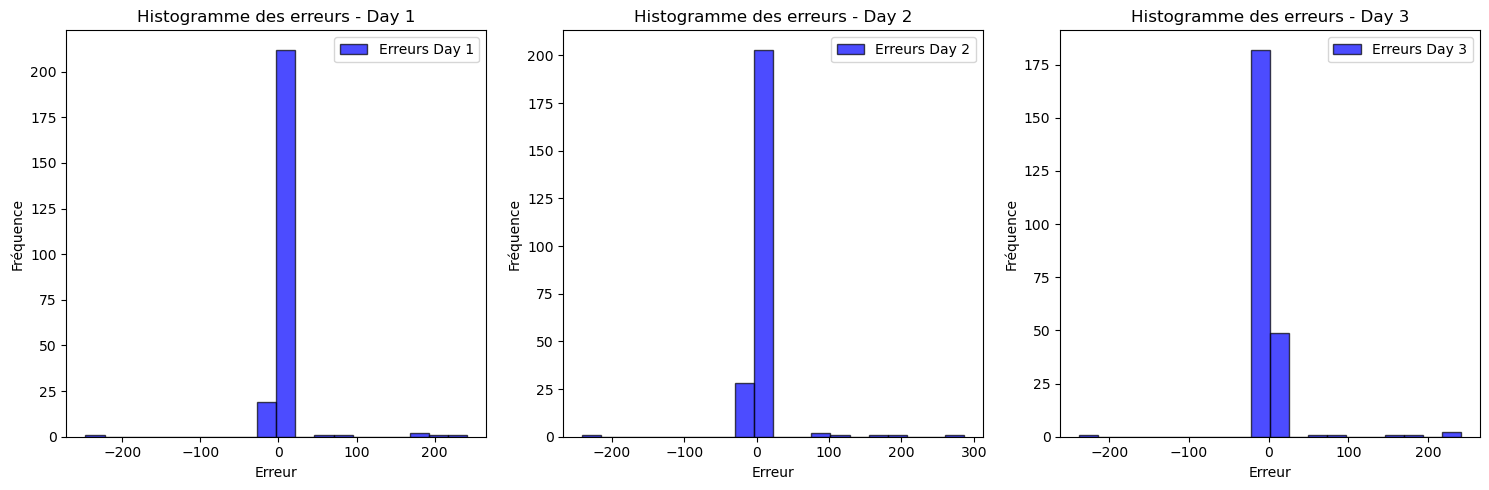

In [74]:
plot_errors_hist_multiple_days(y_train, y_pred_train)

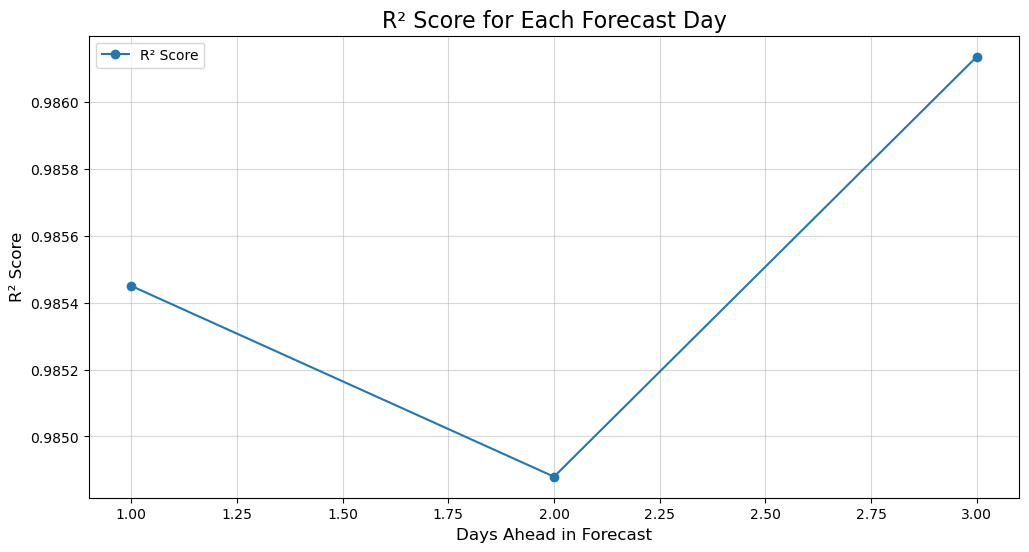

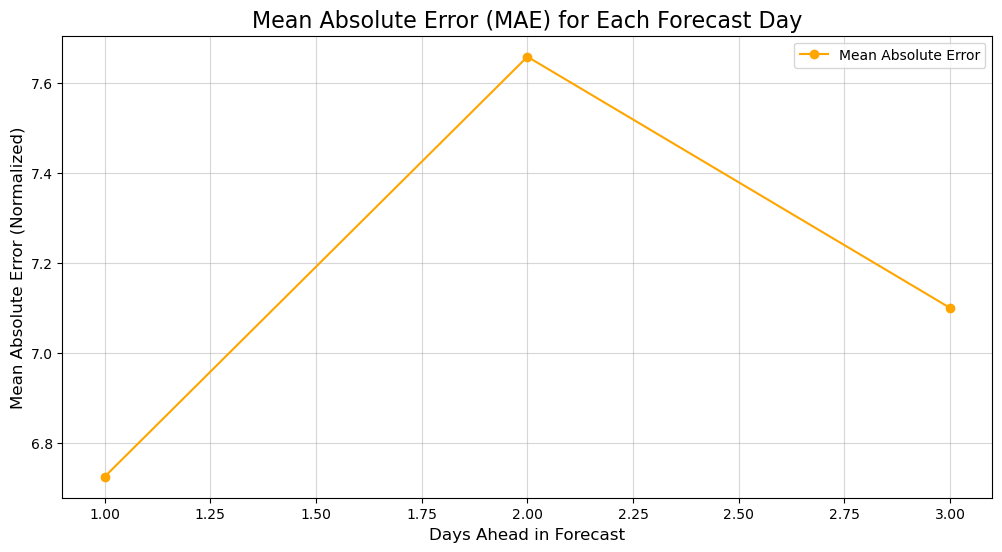

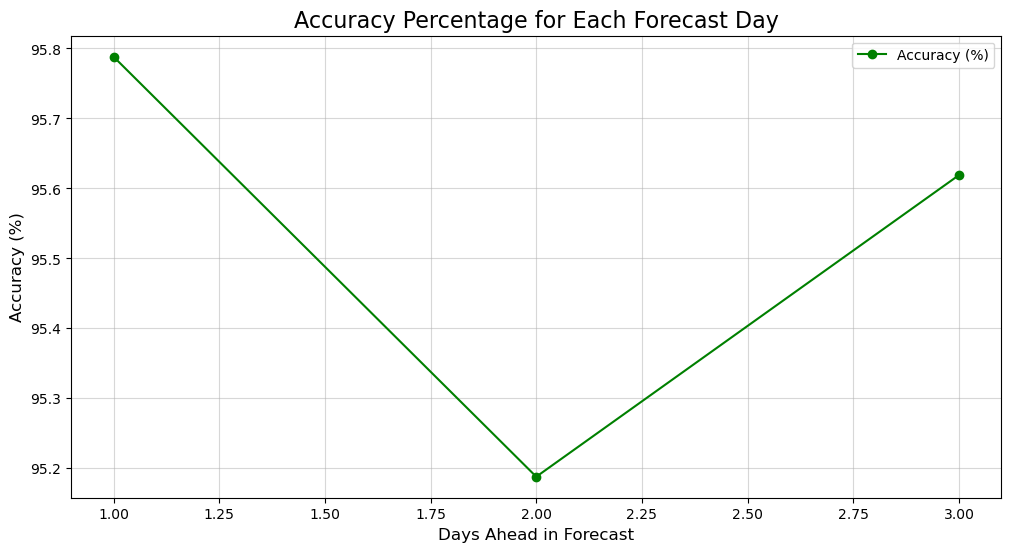

Day 1: Accuracy = 95.79%
Day 2: Accuracy = 95.19%
Day 3: Accuracy = 95.62%


In [75]:
plot_score_per_day(y_train, y_pred_train)

## Test

In [76]:
y_pred_test = model.predict([X_test_tech, X_test_fund])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [77]:
get_performance_metrics_multiple_days(y_test, y_pred_test)

{'Day 1': {'RMSE': np.float64(287.3985154788458),
  'MAE': 90.17774561948555,
  'R²': 0.6565563209922134,
  'NMAE': np.float64(0.2825024214869742),
  'Accuracy': np.float64(0.0),
  'MAPE': 12.023092780476363,
  'SMAPE': np.float64(11.068016140576555)},
 'Day 2': {'RMSE': np.float64(291.81452819271243),
  'MAE': 91.54704160468523,
  'R²': 0.6522002968154493,
  'NMAE': np.float64(0.2844157908830084),
  'Accuracy': np.float64(1.1627906976744187),
  'MAPE': 12.067192286595292,
  'SMAPE': np.float64(11.23465454380295)},
 'Day 3': {'RMSE': np.float64(286.7200979904682),
  'MAE': 92.570464283921,
  'R²': 0.6559313887239782,
  'NMAE': np.float64(0.29035851647891653),
  'Accuracy': np.float64(1.1627906976744187),
  'MAPE': 13.417154274171494,
  'SMAPE': np.float64(12.16592577620189)}}

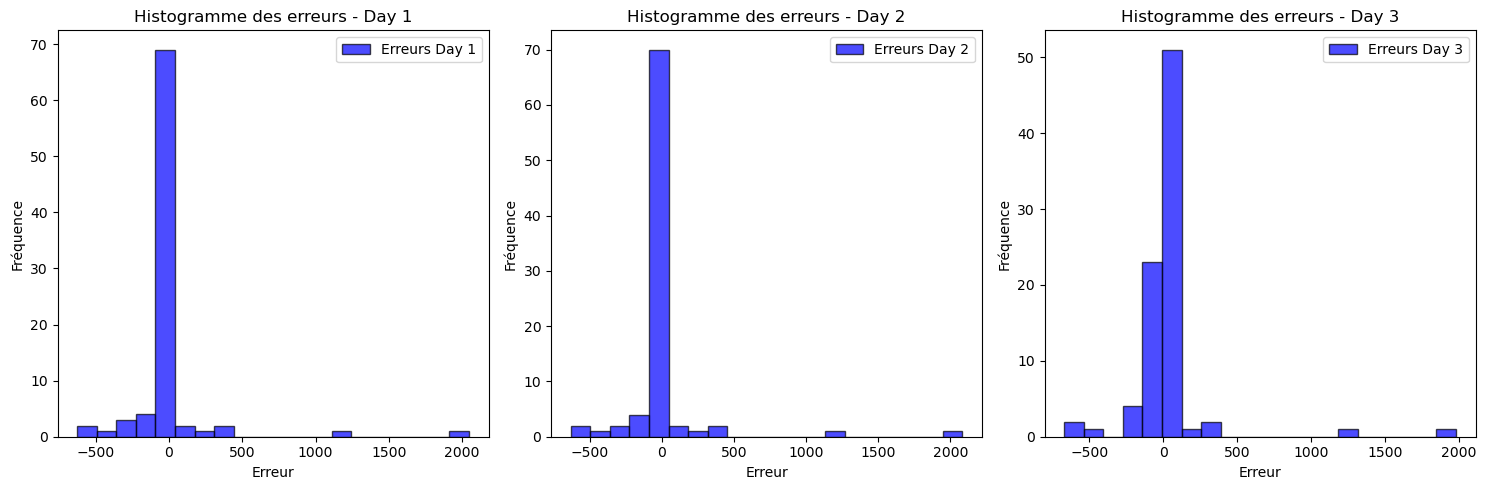

In [78]:
plot_errors_hist_multiple_days(y_test, y_pred_test)

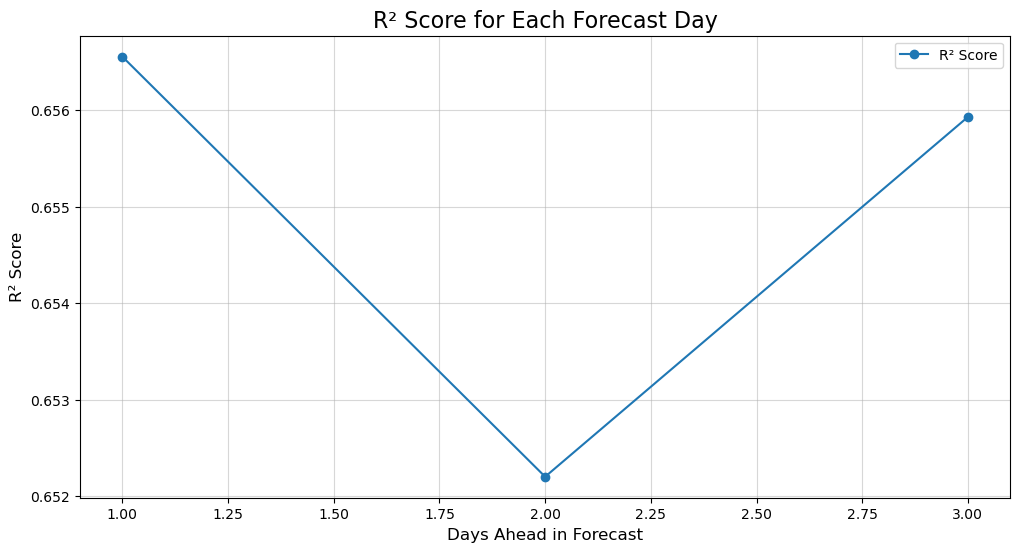

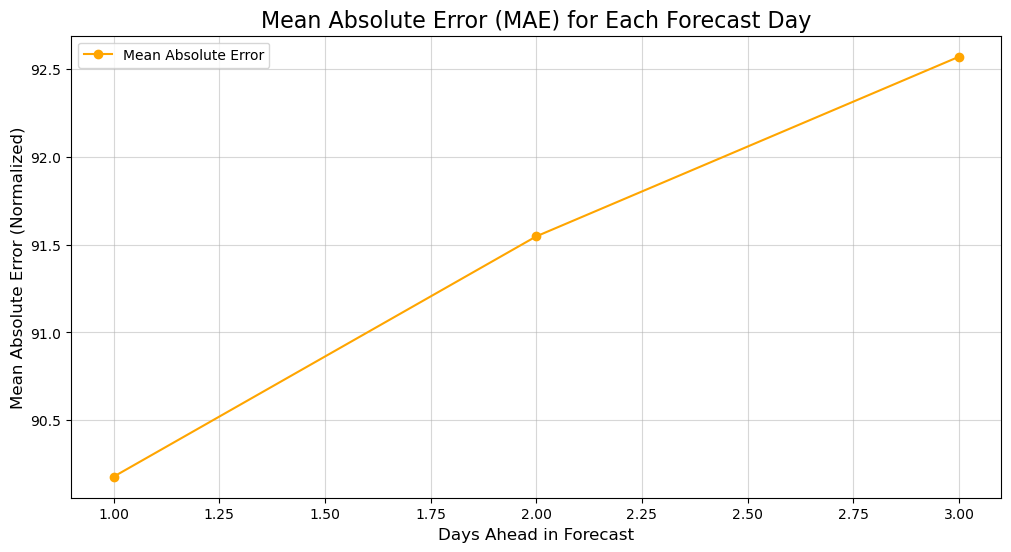

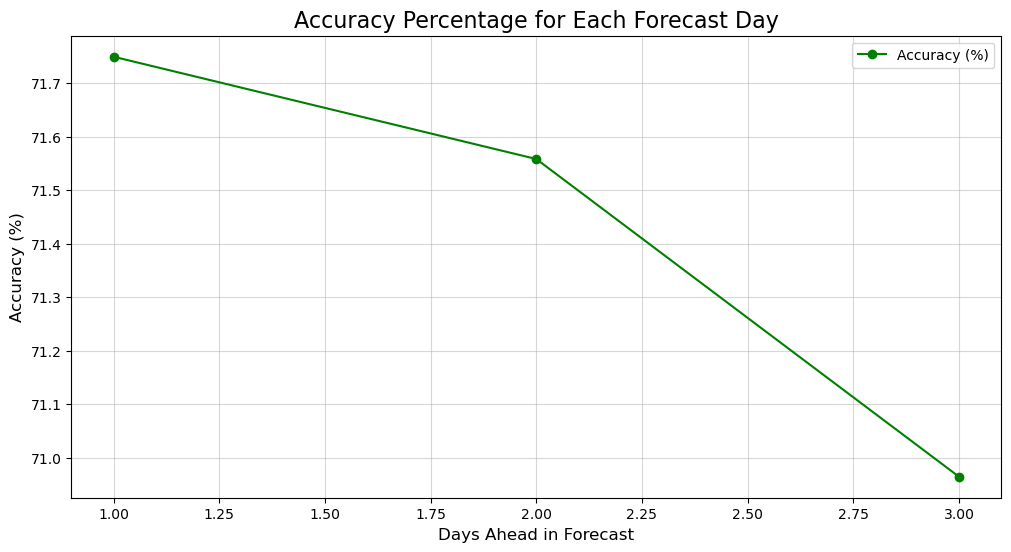

Day 1: Accuracy = 71.75%
Day 2: Accuracy = 71.56%
Day 3: Accuracy = 70.96%


In [79]:
plot_score_per_day(y_test, y_pred_test)